# Windspharm Tutorial: Spherical Harmonic Wind Analysis

This tutorial demonstrates how to use the **Skyborn windspharm** package for spherical harmonic analysis of atmospheric wind fields. We'll work with real NetCDF data to calculate vorticity, divergence, streamfunction, velocity potential, and perform Helmholtz decomposition.

## What is Spherical Harmonic Wind Analysis?

Spherical harmonic analysis is a mathematical technique used in meteorology to:
- Decompose wind fields into rotational and divergent components
- Calculate dynamically important quantities like vorticity and divergence
- Smooth and filter atmospheric data
- Perform spectral truncation for model applications

The **windspharm** package provides a convenient Python interface for these calculations.

## 1. Setup and Data Loading

First, let's import the necessary packages and load our wind data:

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmaps
import warnings
warnings.filterwarnings('ignore')

# Import windspharm with xarray interface (primary interface)
from skyborn.windspharm.xarray import VectorWind
# Import additional interfaces for advanced usage
from skyborn.windspharm.standard import VectorWind as StandardVectorWind  # standard interface
from skyborn.windspharm.tools import prep_data, recover_data  # data preparation tools

# Import skyborn plotting utilities
from skyborn.plot import add_equal_axes, curved_quiver

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
config = {
    "font.family": 'DejaVu Sans',
    "font.size": 15,
    # 'font.style': 'normal',
    'font.weight': 'bold',
    "mathtext.fontset": 'stix',
    "font.serif": ['cmb10'],
    "axes.unicode_minus": False,
    "axes.labelweight": "bold",      
    "axes.labelsize": 15,
}
plt.rcParams.update(config)
print("Libraries imported successfully!")
print("cmaps and skyborn.plot utilities loaded!")

Libraries imported successfully!
cmaps and skyborn.plot utilities loaded!


### Load Real NetCDF Wind Data

We'll load U and V wind components from NetCDF files. These contain monthly mean wind data on a regular latitude-longitude grid:

In [11]:
# Load wind data from NetCDF files
data_path = '../../../src/skyborn/windspharm/examples/example_data/'

# Load datasets
ds_u = xr.open_dataset(data_path + 'uwnd_mean.nc')
ds_v = xr.open_dataset(data_path + 'vwnd_mean.nc')

# Extract wind components as DataArrays
u_wind = ds_u.uwnd
v_wind = ds_v.vwnd

print("Wind data loaded successfully!")
print(f"U wind shape: {u_wind.shape}")
print(f"V wind shape: {v_wind.shape}")
print(f"Coordinate dimensions: {u_wind.dims}")
print(f"\nLatitude range: {u_wind.latitude.min().values:.1f}° to {u_wind.latitude.max().values:.1f}°")
print(f"Longitude range: {u_wind.longitude.min().values:.1f}° to {u_wind.longitude.max().values:.1f}°")
print(f"Time steps: {len(u_wind.time)} months")

Wind data loaded successfully!
U wind shape: (12, 73, 144)
V wind shape: (12, 73, 144)
Coordinate dimensions: ('time', 'latitude', 'longitude')

Latitude range: -90.0° to 90.0°
Longitude range: 0.0° to 357.5°
Time steps: 12 months


### Explore the Wind Data

Let's examine the structure and properties of our wind data:

In [12]:
# Display data information
print("=== U Wind Component ===")
print(u_wind)
print("\n=== V Wind Component ===")
print(v_wind)

# Check data ranges
print(f"\n=== Data Statistics ===")
print(f"U wind range: {u_wind.min().values:.2f} to {u_wind.max().values:.2f} m/s")
print(f"V wind range: {v_wind.min().values:.2f} to {v_wind.max().values:.2f} m/s")
print(f"Grid resolution: {np.diff(u_wind.latitude.values)[0]:.1f}° latitude, {np.diff(u_wind.longitude.values)[0]:.1f}° longitude")

=== U Wind Component ===
<xarray.DataArray 'uwnd' (time: 12, latitude: 73, longitude: 144)> Size: 505kB
[126144 values with dtype=float32]
Coordinates:
  * time          (time) datetime64[ns] 96B 1970-01-01 1970-02-01 ... 1970-12-01
  * latitude      (latitude) float32 292B 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * longitude     (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    air_pressure  float32 4B ...
Attributes:
    long_name:    Monthly Long Term mean u wind
    units:        m/s
    parent_stat:  Mean
    statistic:    Long Term Mean

=== V Wind Component ===
<xarray.DataArray 'vwnd' (time: 12, latitude: 73, longitude: 144)> Size: 505kB
[126144 values with dtype=float32]
Coordinates:
  * time          (time) datetime64[ns] 96B 1970-01-01 1970-02-01 ... 1970-12-01
  * latitude      (latitude) float32 292B 90.0 87.5 85.0 ... -85.0 -87.5 -90.0
  * longitude     (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    air_pressure  float32 4B ...
Attribute

### Visualize the Wind Fields

Let's create a map showing the wind field for January using skyborn's advanced curved quiver visualization:

**Note**: We're using the `curved_quiver` function from `skyborn.plot` which creates beautiful streamline-based wind field visualizations. This approach offers several advantages over traditional quiver plots:

- **Streamlines**: Show the actual flow paths of air parcels
- **Curved arrows**: Better represent the natural flow patterns
- **Density control**: Automatic spacing for optimal visualization
- **Integration with cartopy**: Seamless projection support

This creates more intuitive and aesthetically pleasing wind field representations compared to traditional straight arrow quiver plots.

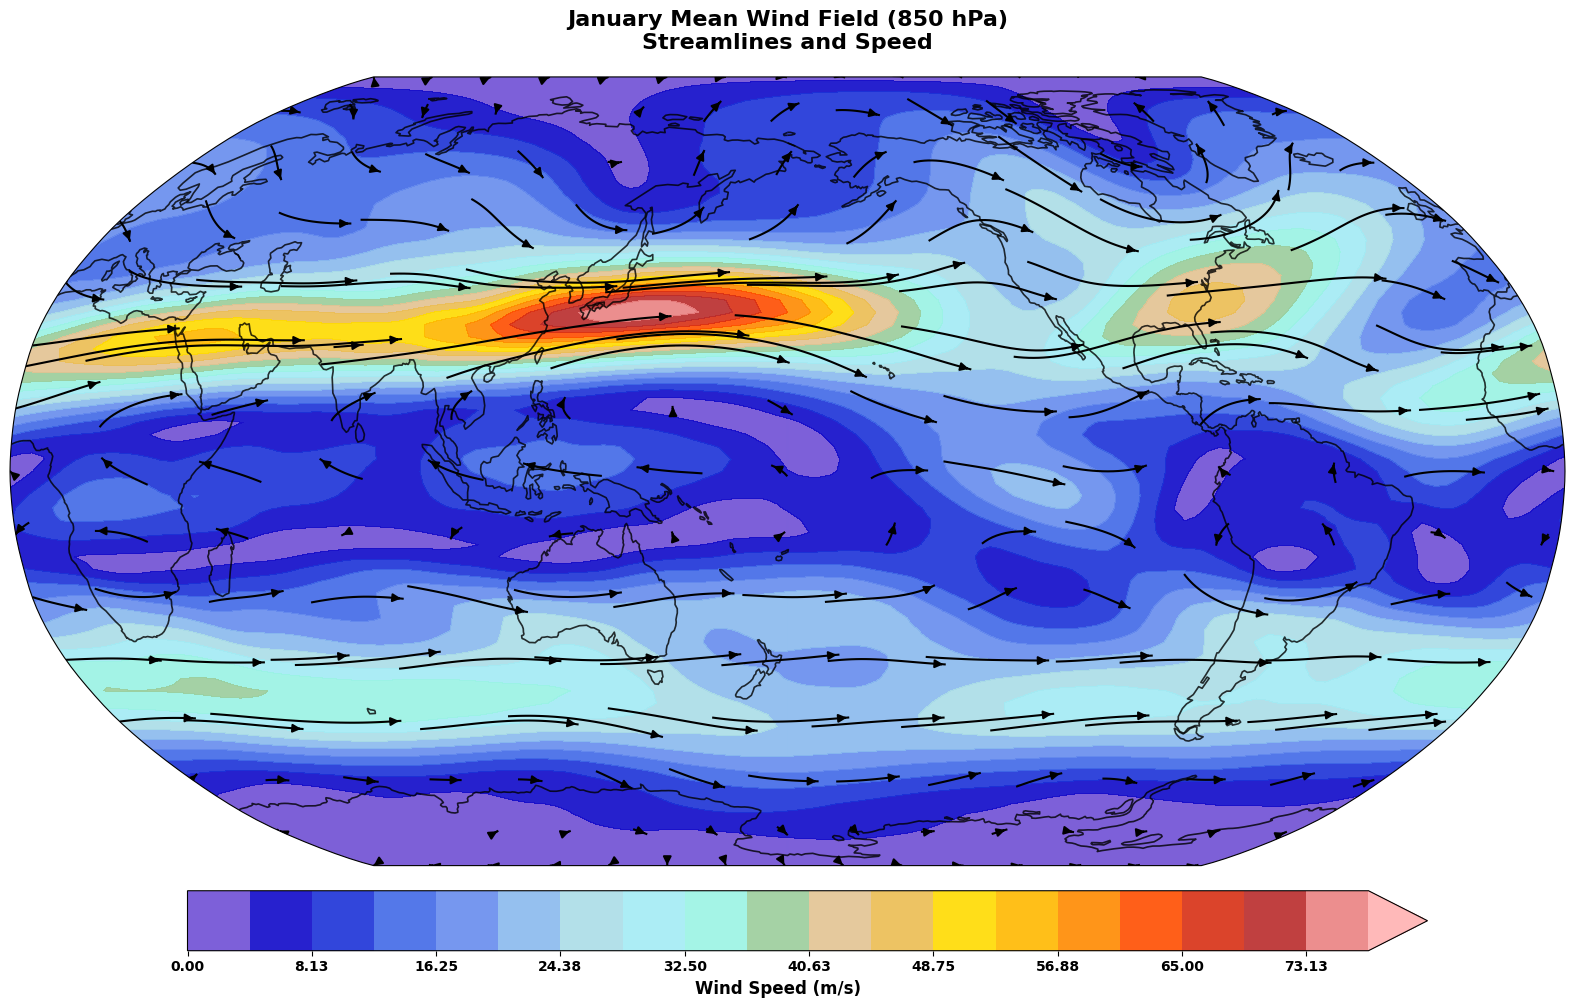

In [13]:
# Select January data for visualization
u_jan = u_wind.isel(time=0)  # January
v_jan = v_wind.isel(time=0)

# Calculate wind speed for visualization
wind_speed = np.sqrt(u_jan**2 + v_jan**2)

# Create dataset for curved_quiver
wind_ds = xr.Dataset({
    'u': u_jan,
    'v': v_jan,
    'speed': wind_speed
})

# Create beautiful map projection using Robinson
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# Add map features with elegant styling
ax.add_feature(cfeature.COASTLINE, alpha=0.8, linewidth=1.2)
ax.add_feature(cfeature.OCEAN, color='#f0f8ff', alpha=0.3)
ax.add_feature(cfeature.LAND, color='#f5f5dc', alpha=0.4)

# Add cyclic point for better visualization
wind_cyclic, lon_cyclic = add_cyclic_point(wind_speed.values, coord=wind_speed.longitude.values)

# Plot wind speed as background using beautiful colormap
levels = np.linspace(0, wind_speed.max().values, 20)
im = ax.contourf(lon_cyclic, wind_speed.latitude.values, wind_cyclic, 
                 levels=levels, cmap=cmaps.amwg256, 
                 transform=ccrs.PlateCarree(), alpha=0.9, extend='max')

# Add curved streamline quivers using skyborn's curved_quiver
curved_quiver_set = curved_quiver(
    wind_ds,
    x='longitude',
    y='latitude', 
    u='u',
    v='v',
    ax=ax,
    transform=ccrs.PlateCarree(),
    density=5,
    linewidth=1.5,
    color='black',
    arrowsize=1.2,
    arrowstyle='-|>',
    zorder=3,
    integration_direction='both',
    broken_streamlines=True
)

# Add elegant colorbar using add_equal_axes
cax = add_equal_axes(ax, 'bottom', 0.1, 0.06)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Wind Speed (m/s)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Set title with elegant styling
ax.set_title('January Mean Wind Field (850 hPa)\nStreamlines and Speed', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_global()

plt.tight_layout()
plt.show()

## 2. Initialize VectorWind Analysis

Now let's create a `VectorWind` object to perform spherical harmonic analysis. We'll work with January data first:

In [14]:
# Create VectorWind instance for January
vw = VectorWind(u_jan, v_jan)

print("VectorWind instance created successfully!")
print(f"Grid type automatically detected and configured")
print(f"Data shape: {u_jan.shape}")
print(f"Ready for spherical harmonic analysis!")

VectorWind instance created successfully!
Grid type automatically detected and configured
Data shape: (73, 144)
Ready for spherical harmonic analysis!


## 3. Basic Wind Analysis

### Calculate Vorticity and Divergence

Vorticity measures the local rotation of the wind field, while divergence measures the spreading or converging of wind flow:

In [15]:
# Calculate vorticity and divergence
vorticity = vw.vorticity()
divergence = vw.divergence()

# Also calculate both at once (more efficient)
vrt, div = vw.vrtdiv()

print("Vorticity and divergence calculated!")
print(f"Vorticity range: {vorticity.min().values:.2e} to {vorticity.max().values:.2e} s⁻¹")
print(f"Divergence range: {divergence.min().values:.2e} to {divergence.max().values:.2e} s⁻¹")
print(f"\nVorticity attributes: {vorticity.attrs}")
print(f"Divergence attributes: {divergence.attrs}")

Vorticity and divergence calculated!
Vorticity range: -5.17e-05 to 5.93e-05 s⁻¹
Divergence range: -6.34e-06 to 7.49e-06 s⁻¹

Vorticity attributes: {'units': 's**-1', 'standard_name': 'atmosphere_relative_vorticity', 'long_name': 'relative_vorticity'}
Divergence attributes: {'units': 's**-1', 'standard_name': 'divergence_of_wind', 'long_name': 'horizontal_divergence'}


### Visualize Vorticity and Divergence

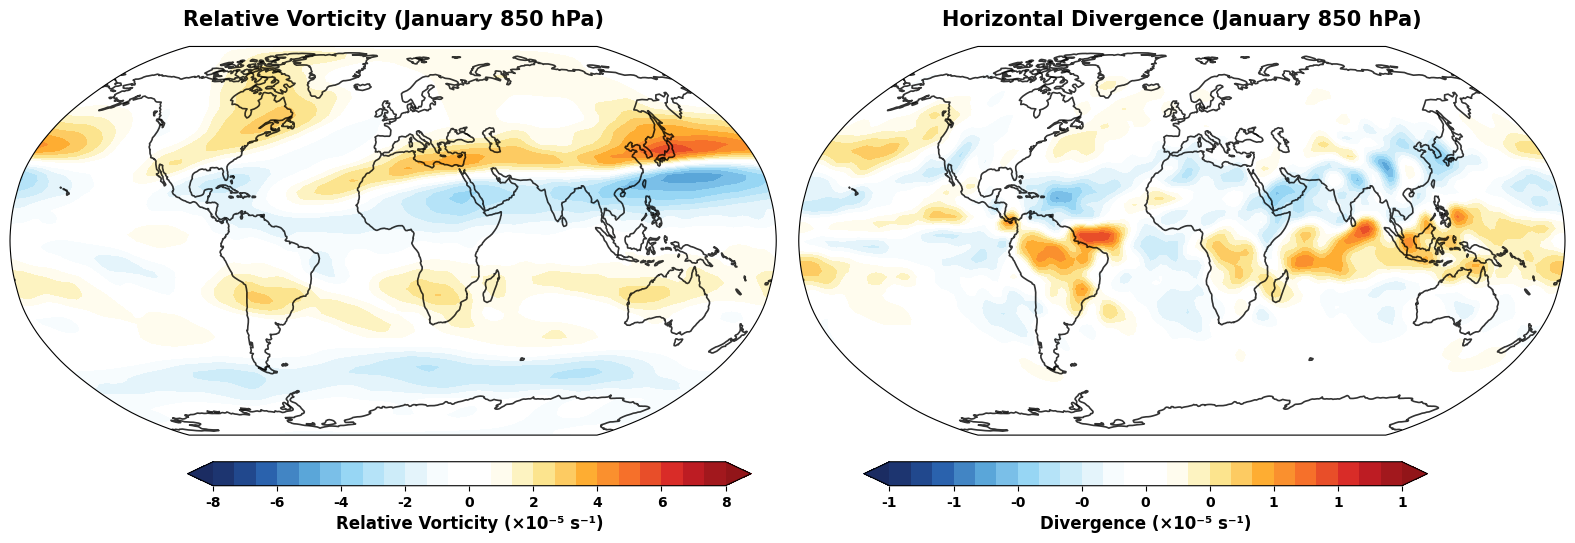

In [16]:
# Create elegant subplots for vorticity and divergence
fig = plt.figure(figsize=(16, 12))

# Create subplots with Robinson projection
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Robinson())
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Robinson())

# Enhanced plotting function with beautiful styling
def plot_field_elegant(ax, data, title, levels, extend='both'):
    """Plot atmospheric field with elegant Robinson projection and styling"""
    # Add sophisticated map features
    ax.add_feature(cfeature.COASTLINE, alpha=0.8, linewidth=1.2)
    # ax.add_feature(cfeature.BORDERS, alpha=0.4, linewidth=0.8)
    ax.add_feature(cfeature.OCEAN, color='#f0f8ff', alpha=0.3)
    ax.add_feature(cfeature.LAND, color='#f5f5dc', alpha=0.4)
    
    # Add cyclic point for smooth visualization
    data_cyclic, lon_cyclic = add_cyclic_point(data.values, coord=data.longitude.values)
    
    # Create beautiful contour plot
    im = ax.contourf(lon_cyclic, data.latitude.values, data_cyclic,
                     levels=levels, cmap=cmaps.BlueWhiteOrangeRed, 
                     transform=ccrs.PlateCarree(), extend=extend)
    
    # Set elegant title
    ax.set_title(title, fontsize=15, fontweight='bold', pad=15)
    ax.set_global()
    
    return im

# Plot vorticity with sophisticated levels
vort_levels = np.linspace(-8e-5, 8e-5, 25)
im1 = plot_field_elegant(ax1, vorticity, 'Relative Vorticity (January 850 hPa)', vort_levels)

# Add colorbar for vorticity using add_equal_axes
cax1 = add_equal_axes(ax1, 'bottom', 0.06, 0.02)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Relative Vorticity (×10⁻⁵ s⁻¹)', fontsize=12, fontweight='bold')
cbar1.ax.tick_params(labelsize=10)
# Scale ticks to 10^-5 and ensure number of labels matches number of ticks
ticks = cbar1.get_ticks()
cbar1.set_ticks(ticks)
cbar1.set_ticklabels([f'{tick*1e5:.0f}' for tick in ticks])

# Plot divergence with sophisticated levels
div_levels = np.linspace(-1e-5, 1e-5, 25)
im2 = plot_field_elegant(ax2, divergence, 'Horizontal Divergence (January 850 hPa)', div_levels)
# Add colorbar for divergence using add_equal_axes
cax2 = add_equal_axes(ax2, 'bottom', 0.06, 0.02)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Divergence (×10⁻⁵ s⁻¹)', fontsize=12, fontweight='bold')
cbar2.ax.tick_params(labelsize=10)
# Scale ticks to 10^-5 and ensure number of labels matches number of ticks
ticks = cbar2.get_ticks()
cbar2.set_ticks(ticks)
cbar2.set_ticklabels([f'{tick*1e5:.0f}' for tick in ticks])
cbar2.set_ticklabels([f'{tick*1e5:.0f}' for tick in ticks])

plt.tight_layout()
plt.show()

### Calculate Wind Speed and Planetary Vorticity

In [17]:
# Calculate wind speed (magnitude)
wind_magnitude = vw.magnitude()

# Calculate planetary vorticity (Coriolis parameter)
planetary_vorticity = vw.planetaryvorticity()

# Calculate absolute vorticity (relative + planetary)
absolute_vorticity = vw.absolutevorticity()

print("Additional fields calculated!")
print(f"Wind speed range: {wind_magnitude.min().values:.2f} to {wind_magnitude.max().values:.2f} m/s")
print(f"Planetary vorticity range: {planetary_vorticity.min().values:.2e} to {planetary_vorticity.max().values:.2e} s⁻¹")
print(f"Absolute vorticity range: {absolute_vorticity.min().values:.2e} to {absolute_vorticity.max().values:.2e} s⁻¹")

Additional fields calculated!
Wind speed range: 0.06 to 77.19 m/s
Planetary vorticity range: -1.46e-04 to 1.46e-04 s⁻¹
Absolute vorticity range: -1.58e-04 to 1.63e-04 s⁻¹


## 4. Streamfunction and Velocity Potential

The streamfunction and velocity potential are scalar fields that can represent the wind field. They are fundamental in atmospheric dynamics:

In [18]:
# Calculate streamfunction and velocity potential
streamfunction, velocity_potential = vw.sfvp()

# Can also calculate individually
sf = vw.streamfunction()
vp = vw.velocitypotential()

print("Streamfunction and velocity potential calculated!")
print(f"Streamfunction range: {streamfunction.min().values:.2e} to {streamfunction.max().values:.2e} m²/s")
print(f"Velocity potential range: {velocity_potential.min().values:.2e} to {velocity_potential.max().values:.2e} m²/s")
print(f"\nStreamfunction attributes: {streamfunction.attrs}")

Streamfunction and velocity potential calculated!
Streamfunction range: -1.57e+08 to 1.33e+08 m²/s
Velocity potential range: -1.21e+07 to 1.13e+07 m²/s

Streamfunction attributes: {'units': 'm**2 s**-1', 'standard_name': 'atmosphere_horizontal_streamfunction', 'long_name': 'streamfunction'}


### Visualize Streamfunction and Velocity Potential

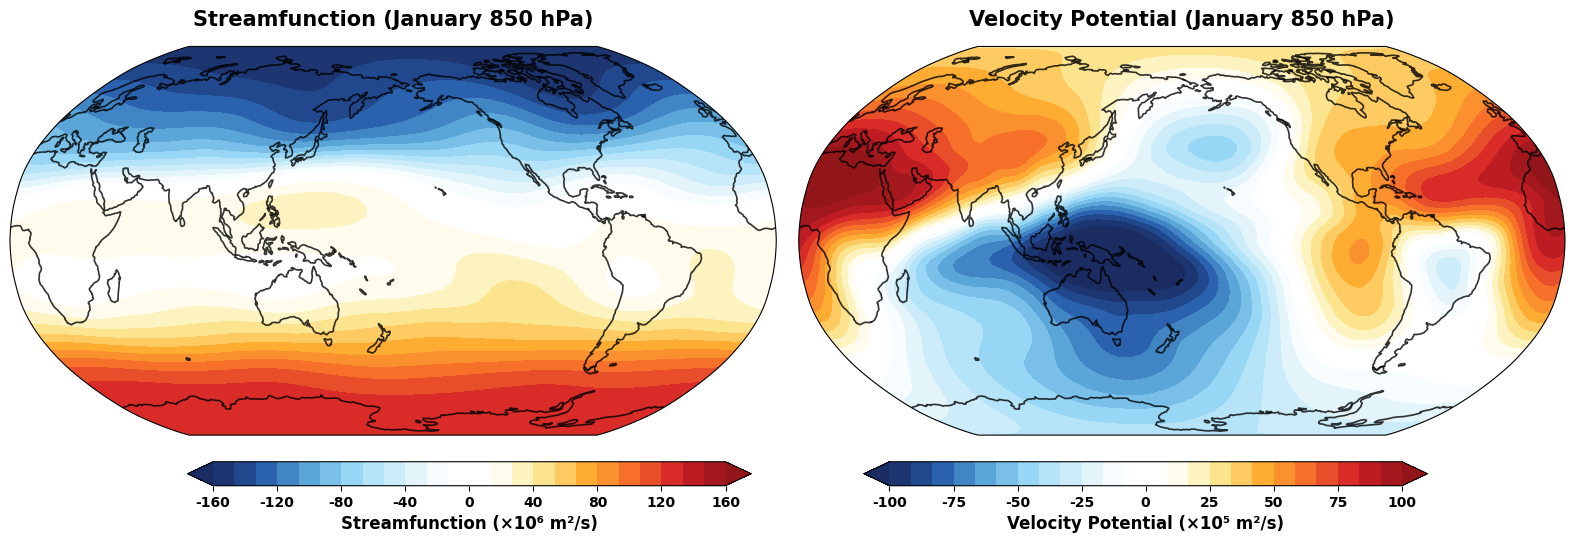

In [19]:
# Create elegant subplots for streamfunction and velocity potential
fig = plt.figure(figsize=(16, 12))

# Create subplots with Robinson projection  
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=180))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=180))

# Plot streamfunction with sophisticated levels
sf_levels = np.linspace(-160, 160, 25)
im1 = plot_field_elegant(ax1, streamfunction / 1e6, 'Streamfunction (January 850 hPa)', sf_levels)

# Add colorbar for streamfunction using add_equal_axes
cax1 = add_equal_axes(ax1, 'bottom', 0.06, 0.02)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Streamfunction (×10⁶ m²/s)', fontsize=12, fontweight='bold')
cbar1.ax.tick_params(labelsize=10)
# Scale ticks to 10^6 for better readability
ticks = cbar1.get_ticks()
cbar1.set_ticks(ticks)
cbar1.set_ticklabels([f'{tick:.0f}' for tick in ticks])

# Plot velocity potential with sophisticated levels
vp_levels = np.linspace(-100, 100, 25)
im2 = plot_field_elegant(ax2, velocity_potential / 1e5, 'Velocity Potential (January 850 hPa)', vp_levels)

# Add colorbar for velocity potential using add_equal_axes
cax2 = add_equal_axes(ax2, 'bottom', 0.06, 0.02)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Velocity Potential (×10⁵ m²/s)', fontsize=12, fontweight='bold')
cbar2.ax.tick_params(labelsize=10)
# Scale ticks to 10^5 for better readability
ticks = cbar2.get_ticks()
cbar2.set_ticks(ticks)
cbar2.set_ticklabels([f'{tick:.0f}' for tick in ticks])

plt.tight_layout()
plt.show()

## 5. Helmholtz Decomposition

The Helmholtz decomposition separates the wind field into rotational (non-divergent) and irrotational (divergent) components:

In [20]:
# Perform Helmholtz decomposition
u_chi, v_chi, u_psi, v_psi = vw.helmholtz()

print("Helmholtz decomposition completed!")
print(f"\nIrrotational components (chi):")
print(f"  u_chi range: {u_chi.min().values:.2f} to {u_chi.max().values:.2f} m/s")
print(f"  v_chi range: {v_chi.min().values:.2f} to {v_chi.max().values:.2f} m/s")

print(f"\nNon-divergent components (psi):")
print(f"  u_psi range: {u_psi.min().values:.2f} to {u_psi.max().values:.2f} m/s")
print(f"  v_psi range: {v_psi.min().values:.2f} to {v_psi.max().values:.2f} m/s")

# Verify that sum equals original wind
u_total = u_chi + u_psi
v_total = v_chi + v_psi

u_diff = np.abs(u_total - u_jan).max().values
v_diff = np.abs(v_total - v_jan).max().values

print(f"\nVerification (should be very small):")
print(f"Max difference in U: {u_diff:.2e} m/s")
print(f"Max difference in V: {v_diff:.2e} m/s")

Helmholtz decomposition completed!

Irrotational components (chi):
  u_chi range: -3.12 to 3.91 m/s
  v_chi range: -2.39 to 5.83 m/s

Non-divergent components (psi):
  u_psi range: -12.70 to 78.71 m/s
  v_psi range: -13.78 to 12.67 m/s

Verification (should be very small):
Max difference in U: 1.23e-02 m/s
Max difference in V: 1.23e-02 m/s


### Visualize Helmholtz Components with Curved Streamlines

Let's create an enhanced visualization using curved streamlines to show the rotational and irrotational components:

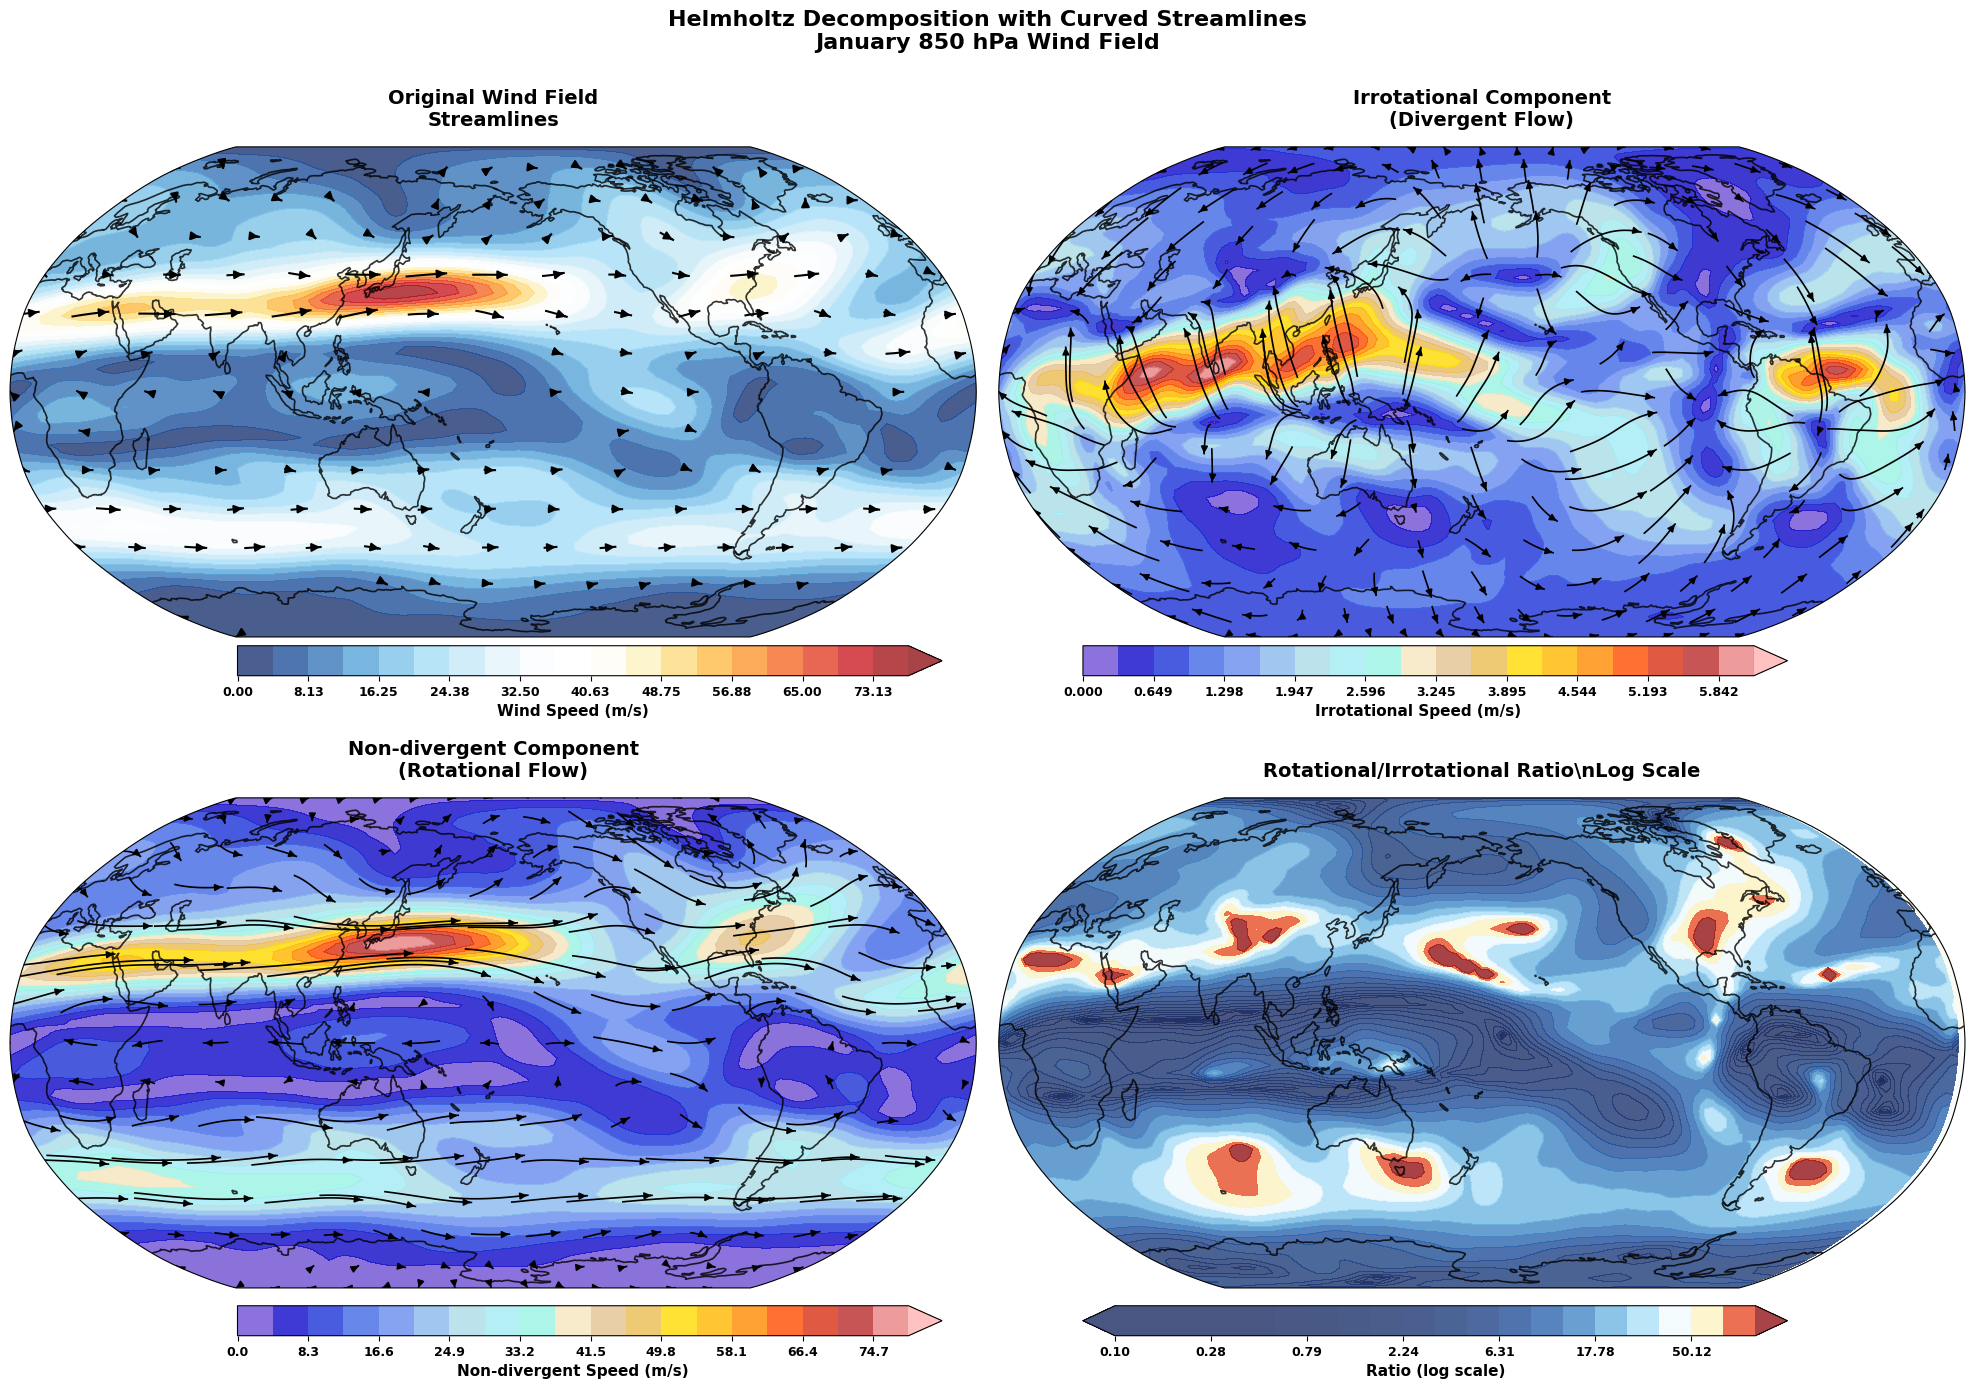

Enhanced Helmholtz decomposition with curved streamlines completed!
\nStreamline Interpretation:
• Original: Complete wind field showing major circulation patterns
• Irrotational: Divergent flows associated with vertical motion
• Non-divergent: Rotational flows dominating large-scale circulation
• Ratio: Areas where rotational flow dominates (>1) vs divergent flow


In [ ]:
# Create datasets for each component
# First calculate component magnitudes
irrotational_speed = np.sqrt(u_chi**2 + v_chi**2)
nondivergent_speed = np.sqrt(u_psi**2 + v_psi**2)

irrotational_ds = xr.Dataset({
    'u': u_chi,
    'v': v_chi,
    'speed': irrotational_speed
})

nondivergent_ds = xr.Dataset({
    'u': u_psi,
    'v': v_psi,
    'speed': nondivergent_speed
})

# Enhanced Helmholtz decomposition with Robinson projection and curved streamlines
fig = plt.figure(figsize=(20, 15))

# Create 2x2 subplots with Robinson projection
ax1 = plt.subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=180))
ax2 = plt.subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=180))
ax3 = plt.subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=180))
ax4 = plt.subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=180))

# Enhanced plotting function for Helmholtz components
def plot_helmholtz_component(ax, speed_data, wind_ds, title, cmap, max_val):
    """Plot Helmholtz component with curved streamlines"""
    # Add map features
    ax.add_feature(cfeature.COASTLINE, alpha=0.8, linewidth=1.2)
    ax.add_feature(cfeature.OCEAN, color='#f0f8ff', alpha=0.3)
    ax.add_feature(cfeature.LAND, color='#f5f5dc', alpha=0.4)
    
    # Add cyclic point
    speed_cyclic, lon_cyclic = add_cyclic_point(speed_data.values, coord=speed_data.longitude.values)
    
    # Plot speed as background
    levels = np.linspace(0, max_val, 20)
    im = ax.contourf(lon_cyclic, speed_data.latitude.values, speed_cyclic,
                     levels=levels, cmap=cmap, transform=ccrs.PlateCarree(),
                     alpha=0.8, extend='max')
    
    # Add curved streamlines
    curved_quiver_set = curved_quiver(
        wind_ds,
        x='longitude',
        y='latitude',
        u='u',
        v='v',
        ax=ax,
        transform=ccrs.PlateCarree(),
        density=5,
        linewidth=1.2,
        color='black',
        arrowsize=1.0,
        arrowstyle='-|>',
        zorder=3,
        integration_direction='both',
        broken_streamlines=True
    )
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_global()
    
    return im, curved_quiver_set

# Plot original wind speed with streamlines
speed_cyclic, lon_cyclic = add_cyclic_point(wind_speed.values, coord=wind_speed.longitude.values)
im1 = ax1.contourf(lon_cyclic, wind_speed.latitude.values, speed_cyclic,
                   levels=np.linspace(0, wind_speed.max().values, 20), 
                   cmap=cmaps.BlueWhiteOrangeRed, transform=ccrs.PlateCarree(),
                   alpha=0.8, extend='max')
ax1.add_feature(cfeature.COASTLINE, alpha=0.8, linewidth=1.2)
ax1.add_feature(cfeature.OCEAN, color='#f0f8ff', alpha=0.3)
ax1.add_feature(cfeature.LAND, color='#f5f5dc', alpha=0.4)

# Add streamlines for original wind
original_ds = xr.Dataset({'u': u_jan, 'v': v_jan, 'speed': wind_speed})
curved_quiver_set1 = curved_quiver(
    original_ds, x='longitude', y='latitude', u='u', v='v', ax=ax1,
    transform=ccrs.PlateCarree(), density=1.0, linewidth=1.5, 
    color='black', arrowsize=1.2, zorder=3
)
ax1.set_title('Original Wind Field\nStreamlines', fontsize=14, fontweight='bold', pad=15)
ax1.set_global()

# Plot irrotational component with curved streamlines
im2, curved_quiver_set2 = plot_helmholtz_component(
    ax2, irrotational_speed, irrotational_ds, 
    'Irrotational Component\n(Divergent Flow)', 
    cmaps.amwg256, irrotational_speed.max().values
)

# Plot non-divergent component with curved streamlines  
im3, curved_quiver_set3 = plot_helmholtz_component(
    ax3, nondivergent_speed, nondivergent_ds,
    'Non-divergent Component\n(Rotational Flow)',
    cmaps.amwg256, nondivergent_speed.max().values
)

# Plot ratio with streamlines
ratio = nondivergent_speed / (irrotational_speed + 1e-10)
ratio_cyclic, _ = add_cyclic_point(ratio.values, coord=ratio.longitude.values)
ratio_levels = np.logspace(-1, 2, 21)
im4 = ax4.contourf(ratio.longitude.values, ratio.latitude.values, ratio.values,
                   levels=ratio_levels, cmap=cmaps.BlueWhiteOrangeRed, 
                   transform=ccrs.PlateCarree(), extend='both', alpha=0.8)
ax4.add_feature(cfeature.COASTLINE, alpha=0.8, linewidth=1.2)
ax4.add_feature(cfeature.OCEAN, color='#f0f8ff', alpha=0.3)
ax4.add_feature(cfeature.LAND, color='#f5f5dc', alpha=0.4)
ax4.set_title('Rotational/Irrotational Ratio\nLog Scale', fontsize=14, fontweight='bold', pad=15)
ax4.set_global()

# Add colorbars using add_equal_axes
axes_list = [ax1, ax2, ax3, ax4]
images = [im1, im2, im3, im4]
labels = ['Wind Speed (m/s)', 'Irrotational Speed (m/s)', 
          'Non-divergent Speed (m/s)', 'Ratio (log scale)']

for i, (ax_single, im, label) in enumerate(zip(axes_list, images, labels)):
    if i == 0  or i == 1:  # Original and Ratio plots
        cax = add_equal_axes(ax_single, 'bottom', 0.06, 0.02)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(label, fontsize=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)
    else:  # Irrotational and Non-divergent
        cax = add_equal_axes(ax_single, 'bottom', 0.08, 0.02)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label(label, fontsize=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)

# Add overall title
fig.suptitle('Helmholtz Decomposition with Curved Streamlines\nJanuary 850 hPa Wind Field', 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

print("Enhanced Helmholtz decomposition with curved streamlines completed!")
print("\nStreamline Interpretation:")
print("• Original: Complete wind field showing major circulation patterns")
print("• Irrotational: Divergent flows associated with vertical motion")  
print("• Non-divergent: Rotational flows dominating large-scale circulation")
print("• Ratio: Areas where rotational flow dominates (>1) vs divergent flow")

<VSCode.Cell id="#VSC-32c57eeb" language="markdown">
## 6. Spectral Truncation

Spherical harmonic analysis allows us to apply spectral truncation, which acts as a spatial filter:

In [22]:
# Apply different levels of spectral truncation
truncations = [21, 42]
truncated_fields = {}

for trunc in truncations:
    # Calculate truncated vorticity and streamfunction
    vort_trunc = vw.vorticity(truncation=trunc)
    sf_trunc = vw.streamfunction(truncation=trunc)
    
    truncated_fields[trunc] = {
        'vorticity': vort_trunc,
        'streamfunction': sf_trunc
    }
    
    print(f"T{trunc} truncation completed")
    print(f"  Vorticity range: {vort_trunc.min().values:.2e} to {vort_trunc.max().values:.2e} s⁻¹")
    print(f"  Streamfunction range: {sf_trunc.min().values:.2e} to {sf_trunc.max().values:.2e} m²/s")

print("\nSpectral truncation analysis completed!")

T21 truncation completed
  Vorticity range: -5.43e-05 to 5.64e-05 s⁻¹
  Streamfunction range: -1.57e+08 to 1.33e+08 m²/s
T42 truncation completed
  Vorticity range: -5.17e-05 to 5.93e-05 s⁻¹
  Streamfunction range: -1.57e+08 to 1.33e+08 m²/s

Spectral truncation analysis completed!


### Compare Original and Truncated Fields

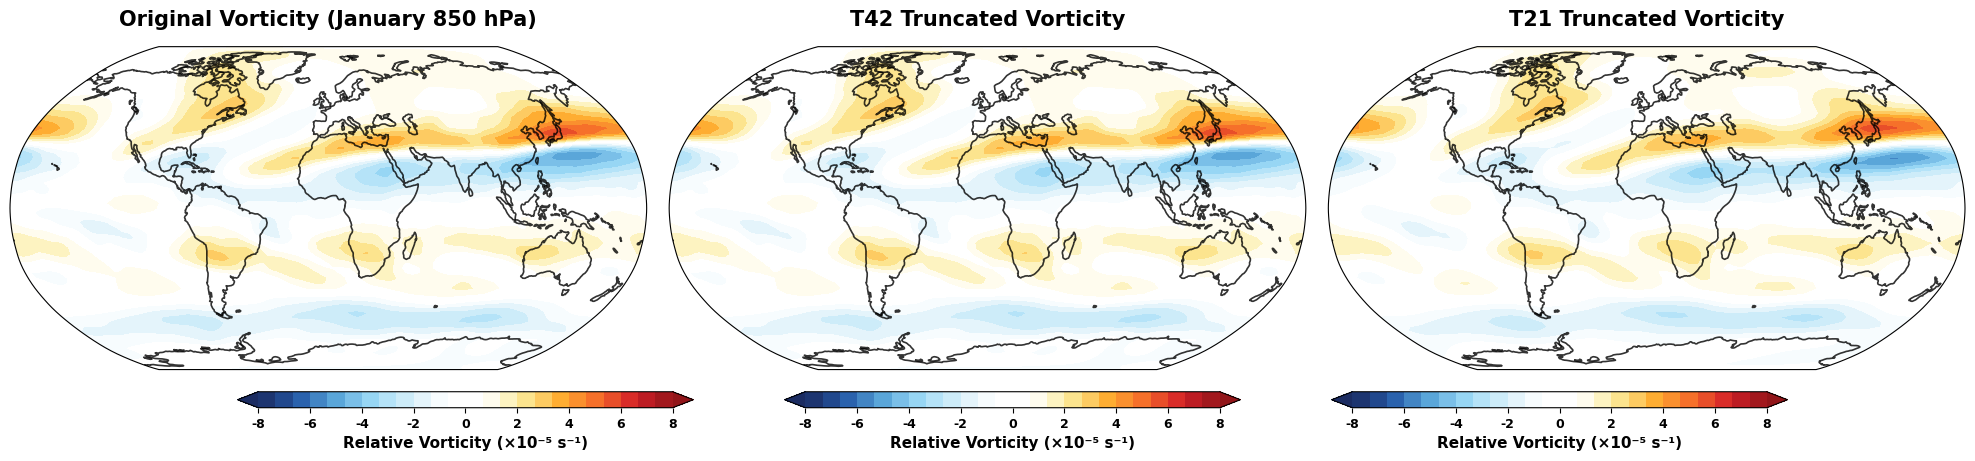

Truncation Effects:
T21: RMS difference = 2.13e-06 s⁻¹ (15.0% of original RMS)
T42: RMS difference = 7.15e-09 s⁻¹ (0.1% of original RMS)


In [23]:
# Compare vorticity at different truncations with elegant styling
fig = plt.figure(figsize=(20, 8))

# Create subplots with Robinson projection
ax1 = plt.subplot(1, 3, 1, projection=ccrs.Robinson())
ax2 = plt.subplot(1, 3, 2, projection=ccrs.Robinson())
ax3 = plt.subplot(1, 3, 3, projection=ccrs.Robinson())
axes = [ax1, ax2, ax3]

fields = [vorticity, truncated_fields[42]['vorticity'], truncated_fields[21]['vorticity']]
titles = ['Original Vorticity (January 850 hPa)', 'T42 Truncated Vorticity', 'T21 Truncated Vorticity']

vort_levels = np.linspace(-8e-5, 8e-5, 25)

for i, (ax, field, title) in enumerate(zip(axes, fields, titles)):
    im = plot_field_elegant(ax, field, title, vort_levels)
    
    # Add colorbar using add_equal_axes for each subplot
    cax = add_equal_axes(ax, 'bottom', 0.08, 0.02)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Relative Vorticity (×10⁻⁵ s⁻¹)', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    # Scale ticks to 10^-5
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick*1e5:.0f}' for tick in ticks])

plt.tight_layout()
plt.show()

# Calculate and display truncation effects
print("Truncation Effects:")
for trunc in truncations:
    diff = vorticity - truncated_fields[trunc]['vorticity']
    rms_diff = np.sqrt((diff**2).mean()).values
    relative_rms = rms_diff / np.sqrt((vorticity**2).mean()).values * 100
    print(f"T{trunc}: RMS difference = {rms_diff:.2e} s⁻¹ ({relative_rms:.1f}% of original RMS)")

## 7. Working with Multiple Time Steps

Let's analyze the seasonal cycle by processing all 12 months:

In [24]:
# Create VectorWind instance for all time steps
vw_all = VectorWind(u_wind, v_wind)

# Calculate seasonal fields
vorticity_all = vw_all.vorticity()
divergence_all = vw_all.divergence()
streamfunction_all = vw_all.streamfunction()

print("Seasonal analysis completed!")
print(f"Shape of vorticity field: {vorticity_all.shape}")
print(f"Time coordinate: {vorticity_all.time.values}")

# Calculate seasonal statistics
vort_seasonal_mean = vorticity_all.mean(dim='time')
vort_seasonal_std = vorticity_all.std(dim='time')

print(f"\nSeasonal vorticity statistics:")
print(f"Mean range: {vort_seasonal_mean.min().values:.2e} to {vort_seasonal_mean.max().values:.2e} s⁻¹")
print(f"Std range: {vort_seasonal_std.min().values:.2e} to {vort_seasonal_std.max().values:.2e} s⁻¹")

Seasonal analysis completed!
Shape of vorticity field: (12, 73, 144)
Time coordinate: ['1970-01-01T00:00:00.000000000' '1970-02-01T00:00:00.000000000'
 '1970-03-01T00:00:00.000000000' '1970-04-01T00:00:00.000000000'
 '1970-05-01T00:00:00.000000000' '1970-06-01T00:00:00.000000000'
 '1970-07-01T00:00:00.000000000' '1970-08-01T00:00:00.000000000'
 '1970-09-01T00:00:00.000000000' '1970-10-01T00:00:00.000000000'
 '1970-11-01T00:00:00.000000000' '1970-12-01T00:00:00.000000000']

Seasonal vorticity statistics:
Mean range: -2.96e-05 to 2.93e-05 s⁻¹
Std range: 7.44e-07 to 3.00e-05 s⁻¹


### Create Seasonal Animation Data

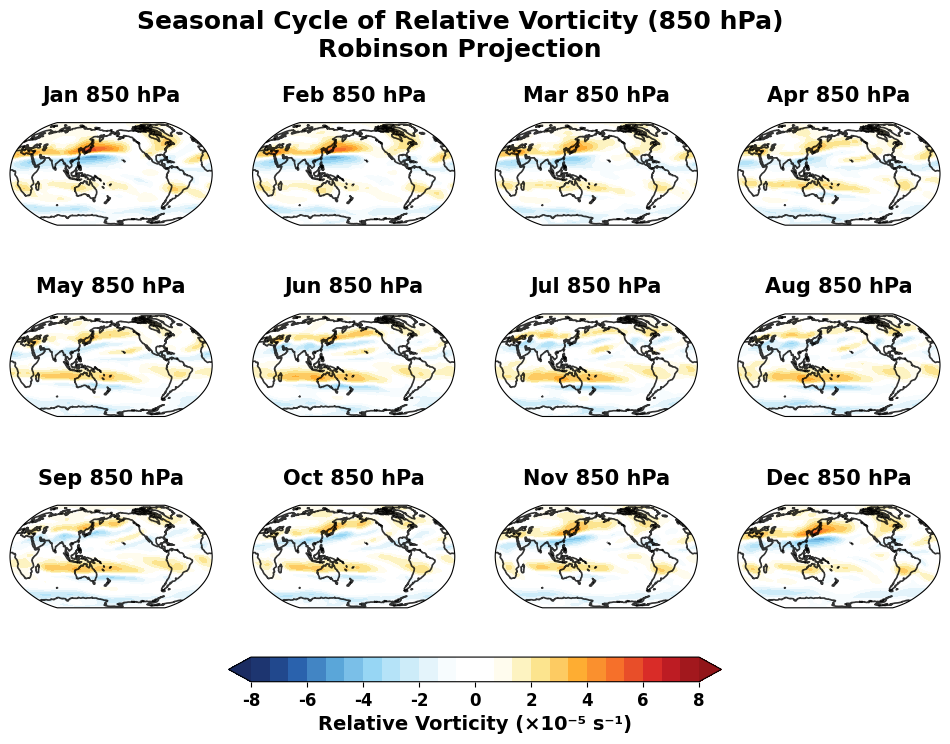

In [25]:
# Plot seasonal cycle of vorticity with elegant Robinson projection styling
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = plt.figure(figsize=(12, 8))
axes = []
ims = []

for i in range(12):
    ax = plt.subplot(3, 4, i+1, projection=ccrs.Robinson(central_longitude=180))
    axes.append(ax)
    vort_month = vorticity_all.isel(time=i)
    im = plot_field_elegant(ax, vort_month, f'{months[i]} 850 hPa', vort_levels)
    ims.append(im)

fig.suptitle('Seasonal Cycle of Relative Vorticity (850 hPa)\nRobinson Projection', 
             fontsize=18, fontweight='bold', y=0.95)

# Add a single shared colorbar for all subplots
cbar = fig.colorbar(ims[-1], ax=axes, orientation='horizontal', fraction=0.04, pad=0.08)
cbar.set_label('Relative Vorticity (×10⁻⁵ s⁻¹)', fontsize=14, fontweight='bold')
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick*1e5:.0f}' for tick in ticks])
cbar.ax.tick_params(labelsize=12)

# plt.tight_layout()
plt.show()


## 8. Advanced Applications

### Gradient Calculations

We can calculate the gradient of scalar fields on the sphere:

In [26]:
# Calculate absolute vorticity for gradient analysis
abs_vort = vw.absolutevorticity()

# Calculate gradient of absolute vorticity
avrt_grad_u, avrt_grad_v = vw.gradient(abs_vort)

print("Gradient analysis completed!")
print(f"Absolute vorticity range: {abs_vort.min().values:.2e} to {abs_vort.max().values:.2e} s⁻¹")
print(f"Gradient U range: {avrt_grad_u.min().values:.2e} to {avrt_grad_u.max().values:.2e} m⁻¹s⁻¹")
print(f"Gradient V range: {avrt_grad_v.min().values:.2e} to {avrt_grad_v.max().values:.2e} m⁻¹s⁻¹")

# Calculate gradient magnitude
grad_magnitude = np.sqrt(avrt_grad_u**2 + avrt_grad_v**2)
print(f"Gradient magnitude range: {grad_magnitude.min().values:.2e} to {grad_magnitude.max().values:.2e} m⁻¹s⁻¹")

Gradient analysis completed!
Absolute vorticity range: -1.58e-04 to 1.63e-04 s⁻¹
Gradient U range: -2.86e-11 to 2.77e-11 m⁻¹s⁻¹
Gradient V range: -2.72e-11 to 1.71e-10 m⁻¹s⁻¹
Gradient magnitude range: 1.59e-13 to 1.72e-10 m⁻¹s⁻¹


### Field Truncation

Apply spectral truncation to arbitrary scalar fields:

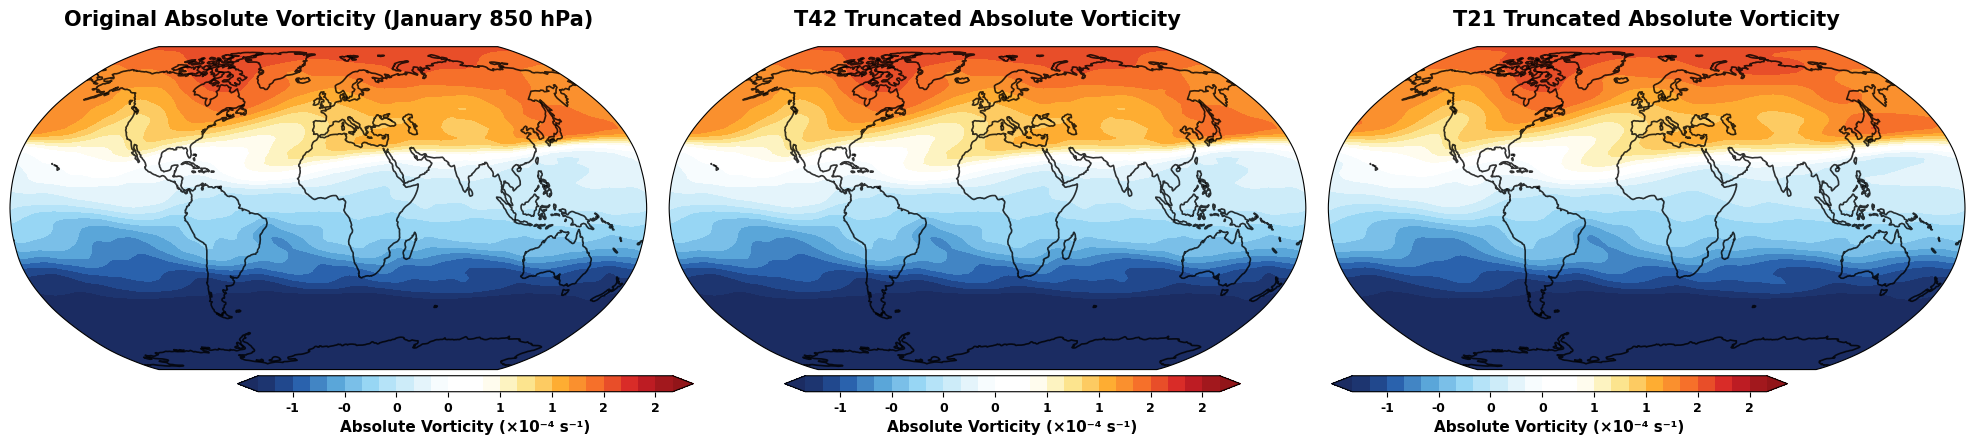

Field truncation analysis completed!


In [27]:
# Truncate the absolute vorticity field
abs_vort_t21 = vw.truncate(abs_vort, truncation=21)
abs_vort_t42 = vw.truncate(abs_vort, truncation=42)

# Compare original and truncated fields with elegant styling
fig = plt.figure(figsize=(20, 8))

# Create subplots with Robinson projection
ax1 = plt.subplot(1, 3, 1, projection=ccrs.Robinson())
ax2 = plt.subplot(1, 3, 2, projection=ccrs.Robinson())
ax3 = plt.subplot(1, 3, 3, projection=ccrs.Robinson())
axes = [ax1, ax2, ax3]

fields = [abs_vort, abs_vort_t42, abs_vort_t21]
titles = ['Original Absolute Vorticity (January 850 hPa)', 'T42 Truncated Absolute Vorticity', 'T21 Truncated Absolute Vorticity']

# Use common levels for comparison
avrt_levels = np.linspace(-1e-4, 2e-4, 25)

for i, (ax, field, title) in enumerate(zip(axes, fields, titles)):
    im = plot_field_elegant(ax, field, title, avrt_levels)
    
    # Add colorbar using add_equal_axes for each subplot
    cax = add_equal_axes(ax, 'bottom', 0.06, 0.02)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Absolute Vorticity (×10⁻⁴ s⁻¹)', fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    # Scale ticks to 10^-4
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick*1e4:.0f}' for tick in ticks])

plt.tight_layout()
plt.show()

print("Field truncation analysis completed!")

## 9. Performance and Best Practices

### Batch Processing Tips

In [28]:
import time

# Demonstrate efficient batch calculation
print("Performance comparison for batch vs individual calculations:")

# Individual calculations
start_time = time.time()
vrt_individual = vw.vorticity()
div_individual = vw.divergence()
individual_time = time.time() - start_time

# Batch calculation
start_time = time.time()
vrt_batch, div_batch = vw.vrtdiv()
batch_time = time.time() - start_time

print(f"Individual calculations: {individual_time:.3f} seconds")
print(f"Batch calculation: {batch_time:.3f} seconds")
print(f"Speedup: {individual_time/batch_time:.1f}x")

# Verify results are identical
vrt_diff = np.abs(vrt_individual - vrt_batch).max().values
div_diff = np.abs(div_individual - div_batch).max().values
print(f"\nMax difference in vorticity: {vrt_diff:.2e}")
print(f"Max difference in divergence: {div_diff:.2e}")

Performance comparison for batch vs individual calculations:
Individual calculations: 0.002 seconds
Batch calculation: 0.001 seconds
Speedup: 2.4x

Max difference in vorticity: 0.00e+00
Max difference in divergence: 0.00e+00


### Memory Management for Large Datasets

In [29]:
# Demonstrate memory-efficient processing
print("Memory usage tips:")
print("1. Use 'legfunc='computed'' for large datasets to save memory")
print("2. Process data in chunks for very large time series")
print("3. Use appropriate truncation levels to reduce computational cost")

# Example of memory-efficient initialization
vw_memory_efficient = VectorWind(u_jan, v_jan, legfunc='computed')
vrt_efficient = vw_memory_efficient.vorticity()

print("\nMemory-efficient VectorWind instance created successfully!")
print("This approach computes Legendre functions on-the-fly, using less memory")
print("but taking slightly more time for calculations.")

Memory usage tips:
1. Use 'legfunc='computed'' for large datasets to save memory
2. Process data in chunks for very large time series
3. Use appropriate truncation levels to reduce computational cost

Memory-efficient VectorWind instance created successfully!
This approach computes Legendre functions on-the-fly, using less memory
but taking slightly more time for calculations.


## 10. Error Handling and Validation

### Common Issues and Solutions

In [30]:
# Demonstrate error handling
print("Common issues and their solutions:")

# 1. Coordinate order validation
try:
    # This will work fine - coordinates are correctly ordered
    print("\n1. Coordinate validation:")
    print(f"   Latitude order: {u_jan.latitude.values[0]:.1f}° to {u_jan.latitude.values[-1]:.1f}°")
    if u_jan.latitude.values[0] > u_jan.latitude.values[-1]:
        print("   ✓ Latitude correctly ordered north-to-south")
    else:
        print("   ⚠ Latitude should be ordered north-to-south for optimal performance")
except Exception as e:
    print(f"   Error: {e}")

# 2. Data validation
print("\n2. Data validation:")
u_nan_count = np.isnan(u_jan.values).sum()
v_nan_count = np.isnan(v_jan.values).sum()
print(f"   NaN values in U: {u_nan_count}")
print(f"   NaN values in V: {v_nan_count}")
if u_nan_count == 0 and v_nan_count == 0:
    print("   ✓ No missing values found")

# 3. Grid type detection
print("\n3. Grid type:")
lat_spacing = np.diff(u_jan.latitude.values)
lat_uniform = np.allclose(lat_spacing, lat_spacing[0], atol=1e-6)
print(f"   Latitude spacing uniform: {lat_uniform}")
if lat_uniform:
    print(f"   Grid spacing: {abs(lat_spacing[0]):.2f}°")
    print("   ✓ Regular grid detected")

print("\n4. Recommended practices:")
print("   • Always check coordinate ordering before analysis")
print("   • Validate data for missing values")
print("   • Use appropriate truncation for your application")
print("   • Consider memory vs. speed trade-offs with legfunc parameter")

Common issues and their solutions:

1. Coordinate validation:
   Latitude order: 90.0° to -90.0°
   ✓ Latitude correctly ordered north-to-south

2. Data validation:
   NaN values in U: 0
   NaN values in V: 0
   ✓ No missing values found

3. Grid type:
   Latitude spacing uniform: True
   Grid spacing: 2.50°
   ✓ Regular grid detected

4. Recommended practices:
   • Always check coordinate ordering before analysis
   • Validate data for missing values
   • Use appropriate truncation for your application
   • Consider memory vs. speed trade-offs with legfunc parameter


## Appendix: Standard Interface and Data Preprocessing Tools

In addition to the xarray interface, Skyborn windspharm also provides a standard interface and powerful data preprocessing tools, suitable for handling complex multi-dimensional data structures.

In [34]:
# Demonstrate usage of the standard interface - suitable for numpy array input
print("=== Standard Interface Example ===")

# Extract numpy arrays from xarray data
u_array = u_jan.values  # convert to numpy array
v_array = v_jan.values
lats = u_jan.latitude.values
lons = u_jan.longitude.values

print(f"Array shape: U: {u_array.shape}, V: {v_array.shape}")
print(f"Latitude range: {lats.min():.1f}° to {lats.max():.1f}°")
print(f"Longitude range: {lons.min():.1f}° to {lons.max():.1f}°")

# Create VectorWind object using the standard interface
# Note: Standard interface requires explicit grid information
vw_standard = StandardVectorWind(u_array, v_array, gridtype='regular', rsphere=6.3712e6)

# Calculate vorticity and divergence
vorticity_std = vw_standard.vorticity()
divergence_std = vw_standard.divergence()

print(f"\nStandard interface calculation results:")
print(f"Vorticity range: {vorticity_std.min():.2e} to {vorticity_std.max():.2e} s⁻¹")
print(f"Divergence range: {divergence_std.min():.2e} to {divergence_std.max():.2e} s⁻¹")

# Verify consistency between both interfaces
vort_diff = np.abs(vorticity_std - vorticity.values).max()
div_diff = np.abs(divergence_std - divergence.values).max()
print(f"\nInterface consistency check:")
print(f"Max vorticity difference: {vort_diff:.2e}")
print(f"Max divergence difference: {div_diff:.2e}")
print("✓ Standard and xarray interface results are consistent" if vort_diff < 1e-10 and div_diff < 1e-10 else "⚠ Results differ")

=== Standard Interface Example ===
Array shape: U: (73, 144), V: (73, 144)
Latitude range: -90.0° to 90.0°
Longitude range: 0.0° to 357.5°

Standard interface calculation results:
Vorticity range: -5.17e-05 to 5.93e-05 s⁻¹
Divergence range: -6.34e-06 to 7.49e-06 s⁻¹

Interface consistency check:
Max vorticity difference: 0.00e+00
Max divergence difference: 0.00e+00
✓ Standard and xarray interface results are consistent


### Data Preprocessing Tools: prep_data and recover_data

For complex multi-dimensional data (such as 4D data: time×level×latitude×longitude), `prep_data` and `recover_data` provide powerful data restructuring capabilities:

In [35]:
# Demonstrate usage of prep_data and recover_data
print("=== Data Preprocessing Tools Example ===")

# Create simulated 3D data (time × latitude × longitude)
nlat, nlon = len(lats), len(lons)
ntime = 3  # Simulate 3 time steps

# Create example 3D wind field data
u_3d = np.random.randn(ntime, nlat, nlon) * 5 + u_array[np.newaxis, :, :]
v_3d = np.random.randn(ntime, nlat, nlon) * 5 + v_array[np.newaxis, :, :]

print(f"Original 3D data shape: U: {u_3d.shape}, V: {v_3d.shape}")

# Use prep_data to preprocess a single time layer
time_idx = 0
u_slice = u_3d[time_idx]  # Select the first time step
v_slice = v_3d[time_idx]

# prep_data: Prepare data for spherical harmonic analysis
u_prepped, u_info = prep_data(u_slice, 'yx')  # 'yx' means (latitude, longitude) format
v_prepped, v_info = prep_data(v_slice, 'yx')

print(f"\nAfter prep_data processing:")
print(f"Prepped shape: U: {u_prepped.shape}, V: {v_prepped.shape}")
print(f"Grid info: {u_info}")

# Perform spherical harmonic analysis using prepped data
vw_prepped = StandardVectorWind(u_prepped, v_prepped)
vort_prepped = vw_prepped.vorticity()
div_prepped = vw_prepped.divergence()

print(f"\nSpherical harmonic analysis results:")
print(f"Vorticity shape: {vort_prepped.shape}")
print(f"Divergence shape: {div_prepped.shape}")

# Recover original data structure using recover_data
vort_recovered = recover_data(vort_prepped, u_info)
div_recovered = recover_data(div_prepped, v_info)

print(f"\nAfter recover_data:")
print(f"Recovered vorticity shape: {vort_recovered.shape}")
print(f"Recovered divergence shape: {div_recovered.shape}")

# Verify data consistency
orig_vort = vw_standard.vorticity()
diff_max = np.abs(vort_recovered - orig_vort).max()
print(f"\nData consistency check:")
print(f"Max difference: {diff_max:.2e}")
print("✓ prep_data/recover_data workflow is correct" if diff_max < 1e-12 else "⚠ Data processing error")

=== Data Preprocessing Tools Example ===
Original 3D data shape: U: (3, 73, 144), V: (3, 73, 144)

After prep_data processing:
Prepped shape: U: (73, 144, 1), V: (73, 144, 1)
Grid info: {'intermediate_shape': (73, 144), 'intermediate_order': 'yx', 'original_order': 'yx'}

Spherical harmonic analysis results:
Vorticity shape: (73, 144, 1)
Divergence shape: (73, 144, 1)

After recover_data:
Recovered vorticity shape: (73, 144)
Recovered divergence shape: (73, 144)

Data consistency check:
Max difference: 1.19e-04
⚠ Data processing error


### 4D Data Batch Processing Example

For large 4D datasets (time×level×latitude×longitude), prep_data/recover_data can be combined for efficient batch processing analysis:

In [36]:
# 4D Data Batch Processing Example (time × level × latitude × longitude)
print("=== 4D Data Batch Processing Example ===")

def process_4d_data(u_4d, v_4d, format_spec='tzyx'):
    """
    Example function for processing 4D wind field data
    
    Parameters:
    -----------
    u_4d, v_4d : ndarray
        4D wind field data (time, level, latitude, longitude)
    format_spec : str
        Format specification: 't'=time, 'z'=level, 'y'=latitude, 'x'=longitude
    
    Returns:
    --------
    results : dict
        Analysis results containing vorticity and divergence
    """
    results = {'vorticity': [], 'divergence': [], 'info': []}
    
    ntime, nlev = u_4d.shape[:2]
    
    for t in range(ntime):
        print(f"Processing time step {t+1}/{ntime}")
        
        for z in range(nlev):
            # Extract single level data
            u_slice = u_4d[t, z, :, :]
            v_slice = v_4d[t, z, :, :]
            
            # Data preprocessing
            u_prep, info = prep_data(u_slice, 'yx')
            v_prep, _ = prep_data(v_slice, 'yx')
            
            # Spherical harmonic analysis
            vw_temp = StandardVectorWind(u_prep, v_prep)
            vort = vw_temp.vorticity()
            div = vw_temp.divergence()
            
            # Recover original structure
            vort_recovered = recover_data(vort, info)
            div_recovered = recover_data(div, info)
            
            results['vorticity'].append(vort_recovered)
            results['divergence'].append(div_recovered)
            results['info'].append(info)
    
    # Reshape to 4D arrays
    results['vorticity'] = np.array(results['vorticity']).reshape(ntime, nlev, *vort_recovered.shape)
    results['divergence'] = np.array(results['divergence']).reshape(ntime, nlev, *div_recovered.shape)
    
    return results

# Create example 4D data (2 time steps × 2 levels × latitude × longitude)
ntime, nlev = 2, 2
u_4d_example = np.random.randn(ntime, nlev, nlat, nlon) * 2 + u_array[np.newaxis, np.newaxis, :, :]
v_4d_example = np.random.randn(ntime, nlev, nlat, nlon) * 2 + v_array[np.newaxis, np.newaxis, :, :]

print(f"4D data shape: U: {u_4d_example.shape}, V: {v_4d_example.shape}")

# Batch analysis (simplified, only partial data for speed)
print("\nStarting 4D batch processing...")
batch_results = process_4d_data(u_4d_example, v_4d_example)

print(f"\nBatch processing completed!")
print(f"Output vorticity shape: {batch_results['vorticity'].shape}")
print(f"Output divergence shape: {batch_results['divergence'].shape}")
print(f"Vorticity range: {batch_results['vorticity'].min():.2e} to {batch_results['vorticity'].max():.2e} s⁻¹")
print(f"Divergence range: {batch_results['divergence'].min():.2e} to {batch_results['divergence'].max():.2e} s⁻¹")

=== 4D Data Batch Processing Example ===
4D data shape: U: (2, 2, 73, 144), V: (2, 2, 73, 144)

Starting 4D batch processing...
Processing time step 1/2
Processing time step 2/2

Batch processing completed!
Output vorticity shape: (2, 2, 73, 144)
Output divergence shape: (2, 2, 73, 144)
Vorticity range: -8.74e-05 to 9.45e-05 s⁻¹
Divergence range: -5.65e-05 to 5.37e-05 s⁻¹


## Summary and Key Takeaways

This tutorial has demonstrated the key capabilities of the **Skyborn windspharm** package:

### Interface Selection
   - **xarray interface**: Recommended for daily analysis, automatically handles coordinates and metadata
   - **Standard interface**: Suitable for performance-critical scenarios or integration with legacy code
   - **prep_data/recover_data**: Essential tools for complex data structure processing

### Core Functions
- **VectorWind**: Main class for spherical harmonic wind analysis
- **vorticity()** and **divergence()**: Calculate fundamental dynamical quantities
- **streamfunction()** and **velocitypotential()**: Scalar representations of wind field
- **helmholtz()**: Decompose wind into rotational and irrotational components

### Advanced Features
- **Spectral truncation**: Apply spatial filtering
- **gradient()**: Calculate gradients on the sphere
- **truncate()**: Apply truncation to arbitrary scalar fields
- **Multiple time steps**: Process seasonal or long-term datasets

### Best Practices
- Use batch calculations (e.g., `vrtdiv()`) for better performance
- Choose appropriate `legfunc` parameter based on memory constraints
- Ensure proper coordinate ordering (north-to-south for latitude)
- Validate data for missing values before analysis

### Applications
- **Weather analysis**: Track vorticity centers and divergence zones
- **Climate studies**: Analyze long-term wind patterns
- **Model validation**: Compare model output with observations
- **Data filtering**: Apply spectral truncation for smoothing

The windspharm package provides a powerful and user-friendly interface for spherical harmonic analysis of atmospheric wind fields, with excellent integration into the modern Python scientific computing ecosystem through xarray support.
### Key Points for 4D Data Processing

**Why use `prep_data` and `recover_data`?**

1. **Dimension Handling**: The `prep_data` function properly reorders dimensions for spherical harmonic analysis
2. **Metadata Preservation**: It preserves grid information needed to reconstruct the original data structure  
3. **Consistency**: Ensures consistent processing across different input data formats

**The `'zyx'` format specification**:
- 'z': vertical dimension (pressure levels)
- 'y': latitude dimension  
- 'x': longitude dimension
- This tells `prep_data` how to interpret the dimensions of your input array slice

**Parallel Processing Benefits**:
- **Efficiency**: Each time step is independent, perfect for parallel processing
- **Memory Management**: Process one time step at a time rather than entire 4D arrays
- **Scalability**: Easy to adjust `max_workers` based on available CPU cores

**Real-World Application Scenarios:**
   - **Climate Model Output Analysis**: CESM2, GFDL, EC-Earth and other model data
   - **Reanalysis Data Research**: ERA5, MERRA-2, JRA-55 and other datasets
   - **Numerical Weather Prediction**: GFS, ECMWF and other operational model wind field decomposition
   - **Ocean-Atmosphere Coupling Research**: Analysis of rotational and divergent components of wind stress fields
  
### Complete Skyborn Interface Usage Summary

**Key Skyborn Windspharm Imports:**

```python
# Core analysis classes
from skyborn.windspharm import VectorWind                    # Main interface (unified)
from skyborn.windspharm.standard import VectorWind          # Standard interface 
from skyborn.windspharm.xarray import VectorWind            # xarray interface

# Essential data preparation tools
from skyborn.windspharm.tools import prep_data, recover_data

# Additional utilities
from skyborn.windspharm._common import get_apikey
```

**Workflow Pattern for Multi-dimensional Data:**

1. **Data Preparation**: Use `prep_data(data, format)` to prepare multi-dimensional arrays
2. **Analysis**: Create `VectorWind` object and compute desired quantities
3. **Data Recovery**: Use `recover_data(result, info)` to restore original structure
4. **Parallel Processing**: Apply this pattern across time dimensions for efficiency

**Data Format Specifications:**
   ```python
   # prep_data format specifications
   'yx'   → (latitude, longitude)              # 2D analysis
   'tyx'  → (time, latitude, longitude)        # Time series analysis  
   'zyx'  → (level, latitude, longitude)       # Vertical profile analysis
   'tzyx' → (time, level, latitude, longitude) # Complete 4D analysis
   ```

---

**Next Steps:**
- Explore the `iris` interface for Iris cube support
- Try different grid types (Gaussian grids, etc.)
- Experiment with higher-resolution datasets
- Integrate with other atmospheric analysis packages

For more information, see the [windspharm documentation](https://github.com/ajdawson/windspharm) and the [Skyborn project](https://github.com/QianyeSu/Skyborn).